# Visualizing the embeddings of BYOL output, hiddem dim == 1024
# For Hoyer dataset (human images)

## Importing the necessary modules

In [12]:
# Importing Necessary Modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sn

import os
import torch

import torch.nn as nn
import lightly

In [4]:
from numpy import int16 # the extended integer type
from numpy import Inf # the infinity value for initializing the loss function
import torchvision # the pytorch library for computer vision
import copy 

import torchvision.transforms as transforms # for image processing (data augmentation)

from lightly.models.modules import BYOLProjectionHead
from lightly.models.utils import deactivate_requires_grad
from lightly.models.utils import update_momentum

# from resnet_monochrome import resnet18 # cuz we are using a ResNet as a backbone for BYOL model
from resnet_monochrome import resnet34
from torch.utils.tensorboard import SummaryWriter # to print to tensorboard during training (online logging)
from torchvision.utils import make_grid # to display images in tensorboard
from datetime import datetime

In [7]:
from typing import List, Union,  Optional, Callable
import torchvision.datasets as datasets

## BYOL class definition

In [8]:
class BYOL(nn.Module):
    def __init__(self, backbone):
        super().__init__()

        self.backbone = backbone
        self.projection_head = BYOLProjectionHead(512, 1024, 256)
        self.prediction_head = BYOLProjectionHead(256, 1024, 256)

        self.backbone_momentum = copy.deepcopy(self.backbone)
        self.projection_head_momentum = copy.deepcopy(self.projection_head)

        deactivate_requires_grad(self.backbone_momentum)
        deactivate_requires_grad(self.projection_head_momentum)

    def forward(self, x):
        y = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(y)
        p = self.prediction_head(z)
        return p

    def forward_momentum(self, x):
        y = self.backbone_momentum(x).flatten(start_dim=1)
        z = self.projection_head_momentum(y)
        z = z.detach()
        return z

In [9]:
gpu = 1

# setting the seed for reproducibility
seed = 0
torch.manual_seed(seed)

# setting the device on which the model will run
device = torch.device(f'cuda:{gpu}' if torch.cuda.is_available() else 'cpu')
print(f'Using device {device}')

# building the model
# resnet = resnet18()
resnet = resnet34()
backbone = nn.Sequential(*list(resnet.children())[:-1])
model = BYOL(backbone)

# state_dict = torch.load('/scratch/gsergei/checkpoints/byol_renal/byol_resnet18_100.ckpt')
# model.load_state_dict(state_dict)
# state_dict = torch.load('/scratch/gsergei/checkpoints/byol_renal_mouse_human_mix/byol_resnet18_850.ckpt')
# state_dict = torch.load('/scratch/gsergei/checkpoints/byol_renal_mouse_human_mix_220901/byol_resnet18_970.ckpt')
state_dict = torch.load('/scratch/gsergei/checkpoints/byol_renal_mouse_human_mix_V4/byol_resnet34_300.ckpt')

# remove the "module." substring from the key names
new_state_dict = {}
for k, v in state_dict.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

Using device cuda:1


In [10]:
# loading the weights into the model from the state dictionary
model.load_state_dict(new_state_dict)
# allocating the model to the GPU
model = model.cuda(gpu)

## Preparing the dataset and loader

### The Dataset class

In [13]:
# class Dataset(lightly.data.LightlyDataset):
class Dataset(lightly.data.LightlyDataset):
    def __init__(self,
                 input_dir: Union[str, None],
                 transform: transforms.Compose = None,
                 index_to_filename:
                 Callable[[datasets.VisionDataset, int], str] = None,
                 filenames: List[str] = None):
        super(Dataset, self).__init__(input_dir)
        
    
    def __getitem__(self, idx):
        fname = self.index_to_filename(self.dataset, idx)
        sample, target = self.dataset.__getitem__(idx)
        # write below two different transformations applied to the same sample ??
        # need to check again how simclr works
        sample2 = self.transforms(sample)
        return sample2[:1,:,:], target, fname
    

    def transforms(self, x): 
        transform = torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=lightly.data.collate.imagenet_normalize['mean'],
            std=lightly.data.collate.imagenet_normalize['std'],)]
        )
        return transform(x)

### The path that stores data for the training

In [14]:
path_data = "/home/gsergei/data/binary_dataset_mix/train"
# path_data = "/home/gsergei/data/mix_mouse_hoyer_imgs/"

### Creating the dataset

In [15]:
# dataset = lightly.data.LightlyDataset(
dataset = Dataset(
    input_dir=path_data,
)

dataloader = torch.utils.data.DataLoader(dataset)

In [13]:
# the place where we will store the embeddings
# embed_dir = './renal_embeds_byol_human_mouse_mix_V3'
embed_dir = './renal_embeds_byol_human_mouse_mix_V7'

if not os.path.isdir(embed_dir):
    os.mkdir(embed_dir)

### Generating the embeddings and saving the in the folder

In [14]:
exclude_list = ['00w', '02w', '04w', '08w', '20w']

model.eval()


for img, _, name in dataloader:
    if name[0].split('_')[0] in exclude_list:
        continue
    img = img.cuda(gpu)
    embedding = model(img)
    torch.save(embedding, os.path.join(embed_dir, name[0][:-4]+'.pth'))

### Inclusive folder with embeddings:

In [17]:
# inclusive w/o exclusions:

embed_dir2 = 'renal_embeds_byol_human_mouse_mix_V8_incl'

model.eval()


for img, _, name in dataloader:
    img = img.cuda(gpu)
    embedding = model(img)
    torch.save(embedding, os.path.join(embed_dir2, name[0][:-4]+'.pth'))

## Loading latent representations into the dictionary

In [15]:
embed_path = embed_dir

embedding_files = list(filter(lambda x: x.endswith('.pth'), os.listdir(embed_path)))
embeds_dict = dict()
embeds_list = list()

for f in embedding_files:
    embedding = torch.load(os.path.join(embed_path, f))
    embedding = torch.flatten(embedding)
    embedding = embedding.cpu().detach().numpy()
    embeds_list.append(embedding)

## Sorting by genotype (mouse subset)

In [16]:
## Grouping embeddings by genotype
root_origin : str = '/home/gsergei/data/renal_images_all'
subdirs_origin : List[str] = ['NTN', 'Adriamycin_Kuehne', '2021_PodR231Q_NTS']

# initialize the dictionary that will store the filenames respective to each genotype
origin_names = dict()
origin_names['adr'] = []
origin_names['ntn'] = []
origin_names['other'] = []

# the anonymous function that will be used to remove extra part of the filename
crop_name = lambda name: name[:-len('_refined.tif')] if ('_refined.tif' in name) else name

# iteratng through the subdirectories and collecting the filenames which are respective to each genotype
for subdir in subdirs_origin:
    fls = os.listdir(os.path.join(root_origin, subdir))
    fls = list(map(crop_name, fls))
    if subdir == 'NTN':
        origin_names['ntn'].extend(fls)
    elif subdir == 'Adriamycin_Kuehne':
        origin_names['adr'].extend(fls)
    else:
        origin_names['other'].extend(fls)

In [17]:
# function designed to find the genotype of the image
def gen_subtype_list(x, origin_names):
    keys = list(origin_names.keys())
    get_short = lambda x: x[:-len('_refined.pth')] if ('_refined.pth' in x) else x
    x = get_short(x)
    for k in keys:
        if x in origin_names[k]:
            return k
    else:
        return 'Human'

In [18]:
# applying the function to the list of filenames
# as a result we get the list of genotypes
subtype_list = list(map(lambda x: gen_subtype_list(x, origin_names), embedding_files))

In [19]:
# creating the hashmap that will store the genotype as a value and the respective embeddings as a key
subtype_embeds = dict()

for i, subtype in enumerate(subtype_list):
    if embedding_files[i] not in subtype_embeds.keys():
        subtype_embeds[embedding_files[i]] = subtype

## Getting t-SNE projections from the embeddings

In [20]:
# initilizing the list of perplexity values for t-SNE algorithm
perplexes = [60, 30, 15, 10, 5]
# initializing the dictionary which will store the results of t-SNE algorithm (dimensionality reduction)
tsne_dfs = dict()

for perpx in perplexes:
    model = TSNE(n_components = 2, random_state = 0, perplexity=perpx, init="pca",
                 verbose=1)
    # init='pca', verbose=1) # try other val-s of perplexity!!
    embeds_np = np.stack(embeds_list)
    tsne_data = model.fit_transform(embeds_np)
    tsne_dfs['perplexity='+str(perpx)] = pd.DataFrame(data={"Name":embedding_files, "Dim_1":tsne_data.T[0,:],
                                "Dim_2":tsne_data.T[1,:], "Subtype":subtype_list})

[t-SNE] Computing 181 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.000s...
[t-SNE] Computed neighbors for 250 samples in 0.007s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 0.110397
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.908596
[t-SNE] KL divergence after 700 iterations: 0.092849
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.000s...
[t-SNE] Computed neighbors for 250 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 0.061501
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.168434
[t-SNE] KL divergence after 1000 iterations: 0.181671
[t-SNE] Computing 46 nearest neighbors...
[t-SNE] Indexed 250 samples in 0.000s...
[t-SNE] Computed neighbors for 250 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 250 / 250
[t-SNE] Mean sigma: 0.039216
[t-SNE] KL divergence after 250 iteratio

In [21]:
# the anonymous function that will be used to remove extra part of the filename '_refined.tif' or '.tif' if it is present
crop_name = lambda name: name[:-len('_refined.tif')] if ('_refined.tif' in name or '.tif' in name) else name
# cropping the filenames
for perpx in perplexes:
    tsne_df = tsne_dfs['perplexity='+str(perpx)]
    tsne_df['Name'] = tsne_df['Name'].apply(crop_name) 

## Loading csv file with morph-l properties

In [22]:
import re
# compile regular expression to check for a number of length > 4 inside "[" and "]"  
rex = re.compile(r'\[(.*)(\d{4,})(.*)\]')
# use the regular expression to write the lambda function that extracts the number from the file name if there's a number
# otherwise return the file name
name2befund = lambda S: rex.findall(S)[0][1] if len(rex.findall(S)) > 0 else S

In [23]:
# compile regular expression to check for a number of length > 4 inside "[" and "]"  
rex = re.compile(r'\[(.*)(\d{4,})(.*)\]')
# use the regular expression to write the lambda function that extracts the number from the file name if there's a number
# otherwise return the file name
name2befund = lambda S: rex.findall(S)[0][1] if len(rex.findall(S)) > 0 else S
for perp in perplexes:
    tsne_df = tsne_dfs['perplexity='+str(perp)]
    tsne_df['ID'] = tsne_df['Name'].apply(name2befund)

In [24]:
# the path to the directory where Hoyer's human data is stored
from operator import index


hoyer_morph_df = pd.read_csv('/home/gsergei/amap/amap_res/morphometry_hoyer/all_params.csv', delimiter='\t',
                             index_col='Unnamed: 0') # human dataset
# the path to the dir where mouse data is stored
mouse_morph_df = pd.read_csv('/home/gsergei/amap/morphometry_mouse_adr-pod-ntn_dataset/all_params.xls', delimiter='\t',
                             index_col='Unnamed: 0') # mouse dataset 
# concatentate two dataframes hoyer_morph_df and mouse_morph_df vertically
morph_df = pd.concat([hoyer_morph_df, mouse_morph_df], axis=0)
f = lambda x: x[:-len('_refined')]
# create a copyt of morph_df - morph_df_ft
morph_df_ft = morph_df.copy()
morph_df_ft['file'] = morph_df_ft['file'].apply(f)
# rename "file" column to "Name" in morph_df_ft
morph_df_ft = morph_df_ft.rename({'file':'Name'}, axis='columns')

In [25]:
morph_df['ID'] = morph_df['file'].apply(name2befund)

In [26]:
# initilizing the list of perplexity values for t-SNE algorithm
# perplexes = [60, 30, 15, 10, 5]

# the empty dictionary that will store merged dataframes
tsne_morph_dfs = dict()

# merging each dataframe in dicrionary tsne_dfs with the dataframe containing the morphological data
for perpx in perplexes:
    tsne_df = tsne_dfs['perplexity='+str(perpx)]
    tsne_morph_dfs['perplexity='+str(perpx)] = pd.merge(morph_df, tsne_df, on='ID', how='outer')

In [27]:
# use it only if you need to get scatter plot with data points equal to the number of images
for perplexity in perplexes:
    # group rows by the column "ID" and take the mean of each group
    tsne_morph_dfs['perplexity='+str(perplexity)] = tsne_morph_dfs['perplexity='+str(perplexity)].groupby('Name').mean()

In [28]:
tsne_cleansed_dfs : dict = {}
edge : float = 0.02 # the threshold value for the outliers

for df_name,df in tsne_morph_dfs.items():
    tsne_cleansed_df = df.copy()
    # bottom boundary for the outliers
    inf_fp_area = tsne_cleansed_df['FP Area'].quantile(edge)
    # top boundary for the outliers
    sup_fp_area = tsne_cleansed_df['FP Area'].quantile(1-edge)
    # selectin the rows that are not outliers
    tsne_cleansed_df = tsne_cleansed_df[(tsne_cleansed_df['FP Area'] > inf_fp_area) & (tsne_cleansed_df['FP Area'] < sup_fp_area)]
    tsne_cleansed_dfs[df_name] = tsne_cleansed_df

In [29]:
# rename index column to "Name" in each dataframe in tsne_cleansed_dfs
for df_name,df in tsne_cleansed_dfs.items():
    tsne_cleansed_dfs[df_name] = df.rename({'Name':'ID'}, axis='columns')

# add a new index column to each dataframe in tsne_cleansed_dfs and set it to be an interger index
for df_name,df in tsne_cleansed_dfs.items():
    tsne_cleansed_dfs[df_name] = df.reset_index()

No handles with labels found to put in legend.


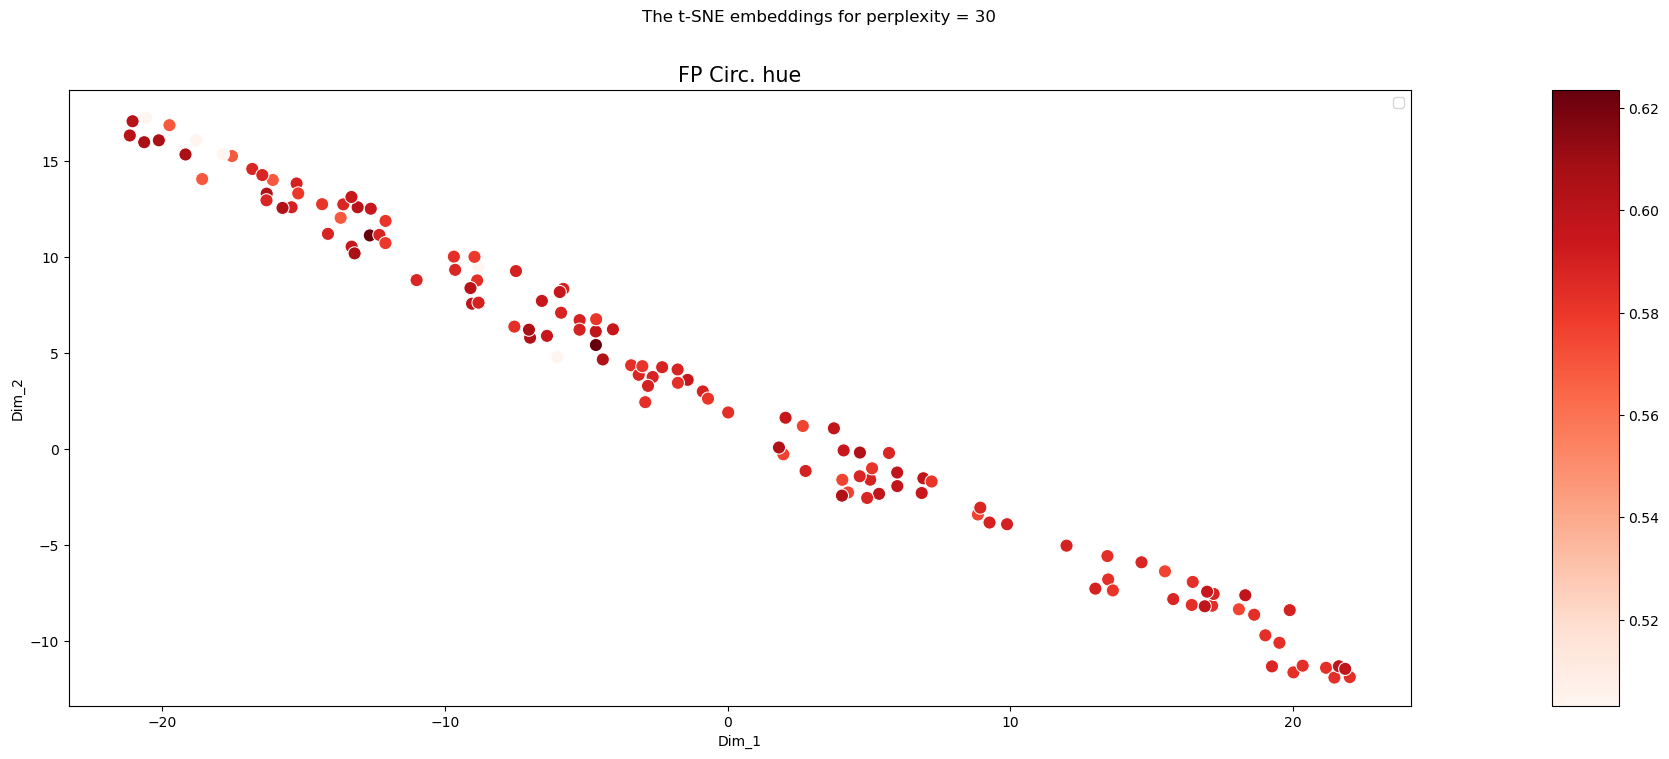

In [30]:
# for the perplexity value of
perplexity : float = 30
hue_param : str = 'FP Circ.'

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,8), gridspec_kw={'width_ratios': [20, 1]},
                    sharey=False)

tsne_cleansed_df = tsne_cleansed_dfs['perplexity='+str(perplexity)]

ax_ = sn.scatterplot(x=tsne_cleansed_df['Dim_1'], y=tsne_cleansed_df['Dim_2'], 
                     hue=tsne_cleansed_df[hue_param], palette='Reds', 
                     s=90, legend=False, ax=axs[0])

plt.suptitle('The t-SNE embeddings for perplexity = {}'.format(perplexity))

ax_.set_title('{} hue'.format(hue_param), fontsize=15)

norm = plt.Normalize(tsne_cleansed_df[hue_param].min(), tsne_cleansed_df[hue_param].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax_.figure.colorbar(sm, cax=axs[1], fraction=0.01, pad=0.01)
ax_.legend()

No handles with labels found to put in legend.


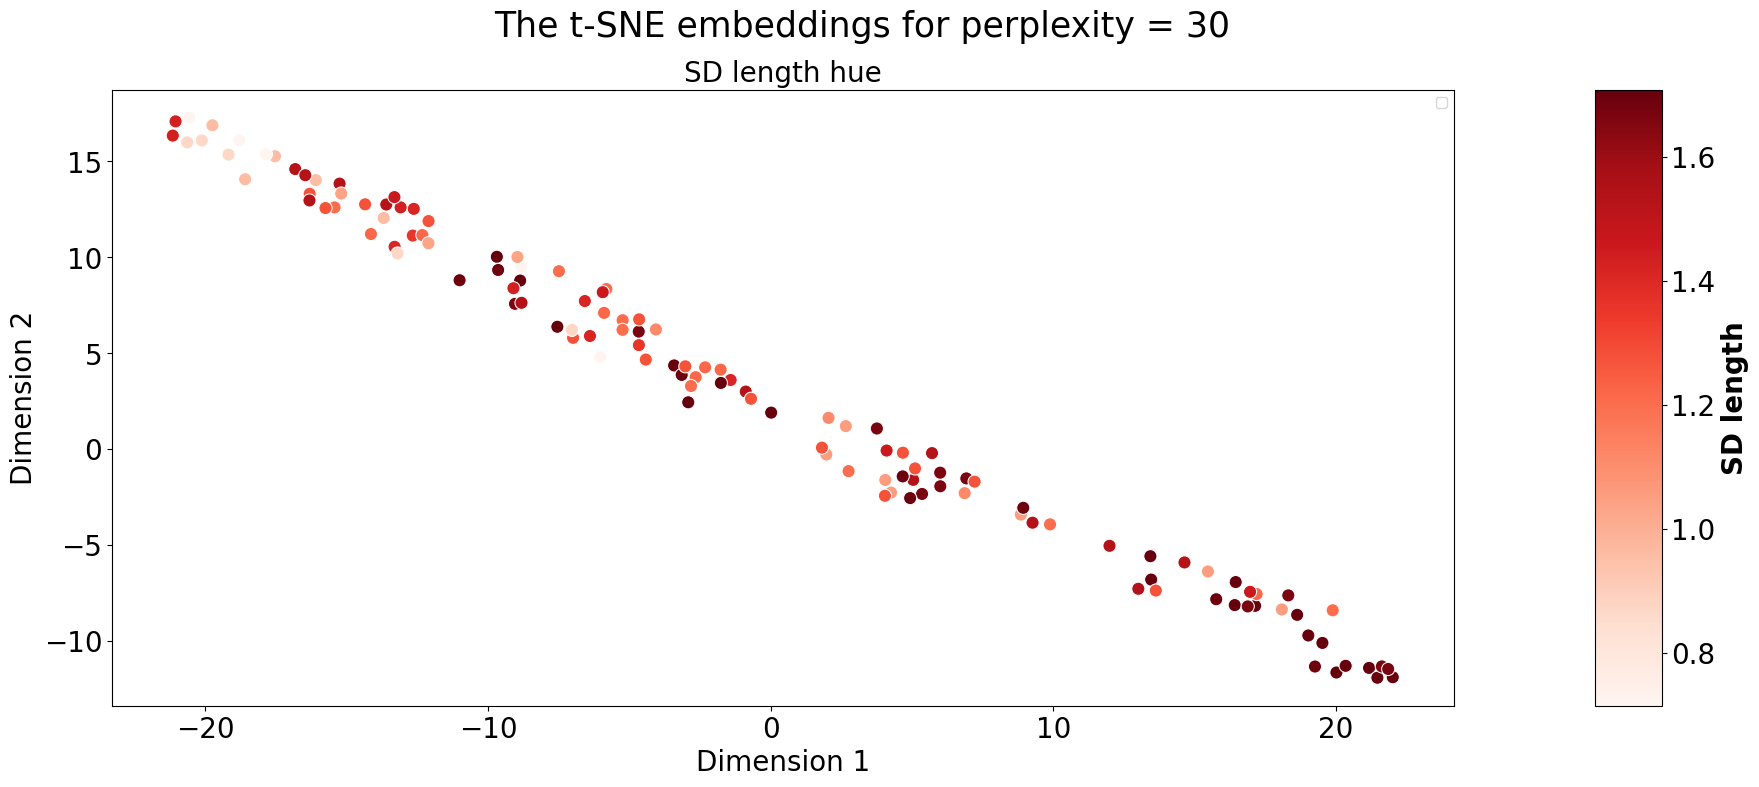

In [31]:
# for the perplexity value of
perplexity : float = 30
hue_param : str = 'SD length'

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,8), gridspec_kw={'width_ratios': [20, 1]},
                    sharey=False)

tsne_cleansed_df = tsne_cleansed_dfs['perplexity='+str(perplexity)]

ax = sn.scatterplot(x=tsne_cleansed_df['Dim_1'], y=tsne_cleansed_df['Dim_2'], 
                     hue=tsne_cleansed_df[hue_param], palette='Reds', 
                     s = 90, legend=False, ax=axs[0])

plt.suptitle('The t-SNE embeddings for perplexity = {}'.format(perplexity),
             fontsize=25)

ax.set_title('{} hue'.format(hue_param), fontsize=20)

ax.figure.axes[0].tick_params(labelsize=20)

ax.figure.axes[1].tick_params(labelsize=20)

ax.figure.axes[0].set_xlabel('Dim_1', fontsize=20)
ax.figure.axes[0].set_ylabel('Dim_2', fontsize=20)

# rename X and Y axes to Dimension 1 and Dimension 2
ax.set_xlabel('Dimension 1', fontsize=20)
ax.set_ylabel('Dimension 2', fontsize=20)

norm = plt.Normalize(tsne_cleansed_df[hue_param].min(), tsne_cleansed_df[hue_param].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
cb = ax.figure.colorbar(sm, cax=axs[1], fraction=0.01, pad=0.01)
cb.set_label(label=hue_param, size=20, weight='bold')
ax.legend()

<AxesSubplot:>

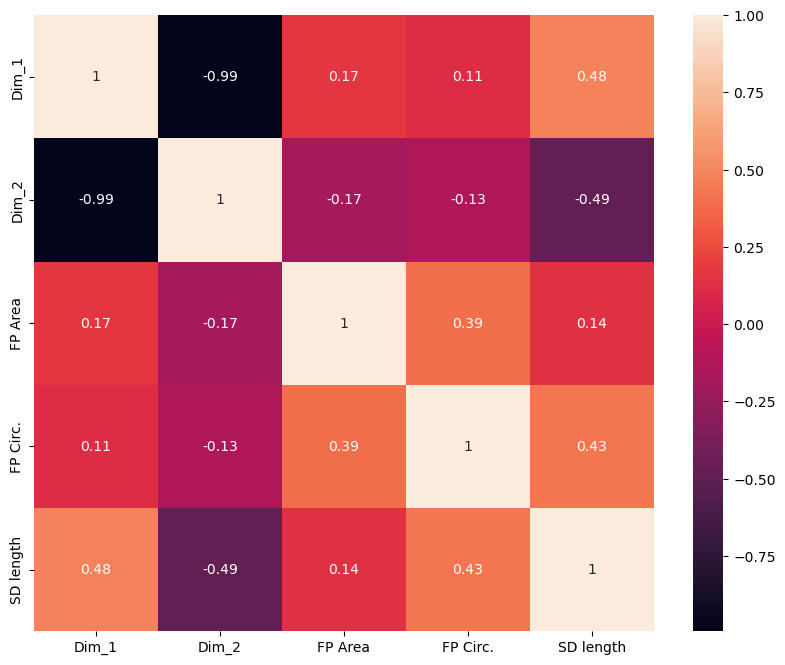

In [32]:
# calculate the correlation matrix between the morphological features and the t-SNE embeddings
correlation_matrix : pd.DataFrame = tsne_cleansed_df[['Dim_1', 'Dim_2', 'FP Area', 'FP Circ.', 'SD length']].corr()

# plot the correlation matrix
fig, ax = plt.subplots(figsize=(10, 8))
sn.heatmap(correlation_matrix, annot=True, ax=ax)

# for the perplexity value of
# perplexity : float = 30
# hue_param : str = 'SD length'

# fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,8), gridspec_kw={'width_ratios': [20, 1]},
#                     sharey=False)


## Building scatter plots for morphometric parameters

In [33]:
# for the perplexity value of
perplexity : float = 30
tsne_morphs_df = tsne_morph_dfs['perplexity='+str(perplexity)]

morph_params = ['FP Area', 'FP Circ.', 'SD length', 'grid crossings']
morph_param = morph_params[3]

# the function for building the scatter plot of the t-SNE embeddings
# with the morphological parameter as the hue
# and subtype as the size
# the arguments are:
# - perplexity: the perplexity value of the t-SNE embeddings
# - morph_param: the morphological parameter to be used as the hue
# - ref_param: the reference parameter to be used as the size
# - save: whether to save the figure to a file
# - save_path: the path to the folder where the figure is to be saved
# - the name of the file is "mix_subtype_morph_p_tsne_perplexity_{}.png".format(perplexity)
# - font size: the font size of the title and the axis labels
# - legend_font_size: the font size of the legend
# - tick_size: the font size of the tick labels
# - title: the title of the figure
# - x_label: the label of the x axis
# - y_label: the label of the y axis
def scatter_tsne_morph_plot(morph_param: str, ref_param: str, 
                            title: str, x_label: str='Dim_1', y_label: str = 'Dim_2', df: pd.DataFrame = tsne_morph_dfs,
                            perplexity: int = 30, save: bool = True,
                            save_path: str = './plots/',
                            font_size: int = 20, legend_font_size: int = 15, 
                            tick_size: int = 20,
                            title_size: int = 25):

    tsne_morphs_df = df['perplexity={}'.format(perplexity)]

    plt.rc('legend',fontsize='x-large')

    fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,8), gridspec_kw={'width_ratios': [30, 1]},
                            sharey=False)

    # ax0 = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
    #                      hue=tsne_morphs_df[ref_param],
    #                      s = 12, legend=True, ax=axs[0])

    ax2 = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
                         hue=tsne_morphs_df[morph_param], palette='Reds', 
                         s = 90, legend=False, ax=axs[0])

    plt.suptitle(title, 
                 fontsize=title_size)

    # ax0.set_title('{} hue'.format(ref_param), fontsize=15)
    ax2.set_title('{} hue'.format(morph_param), fontsize=font_size)


    norm = plt.Normalize(tsne_morphs_df[morph_param].min(), tsne_morphs_df[morph_param].max())
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
    sm.set_array([])

    # ax2.set_title('{} hue'.format(hue_param), fontsize=20)

    ax2.figure.axes[0].tick_params(labelsize=tick_size)
    ax2.figure.axes[1].tick_params(labelsize=tick_size)
    ax2.figure.axes[0].set_xlabel(x_label, fontsize=font_size)
    ax2.figure.axes[0].set_ylabel(y_label, fontsize=font_size)
    
    # rename X and Y axes to Dimension 1 and Dimension 2
    ax2.set_xlabel('Dimension 1', fontsize=20)
    ax2.set_ylabel('Dimension 2', fontsize=20)

    cb = ax2.figure.colorbar(sm, cax=axs[1], fraction=0.01, pad=0.01)
    # cb.set_label(label='a label', weight='bold')
    cb.set_label(label='grid crossing hue',size=legend_font_size,weight='bold')
    # ax2.legend()
    
    if save:
        # save the figure to a file named "mix_subtype_morph_p_tsne_perplexity_{}.png".format(perplexity) in the folder "./plots"
        plt.savefig(save_path, facecolor='w')
    else:
        plt.show()
        
    plt.close()

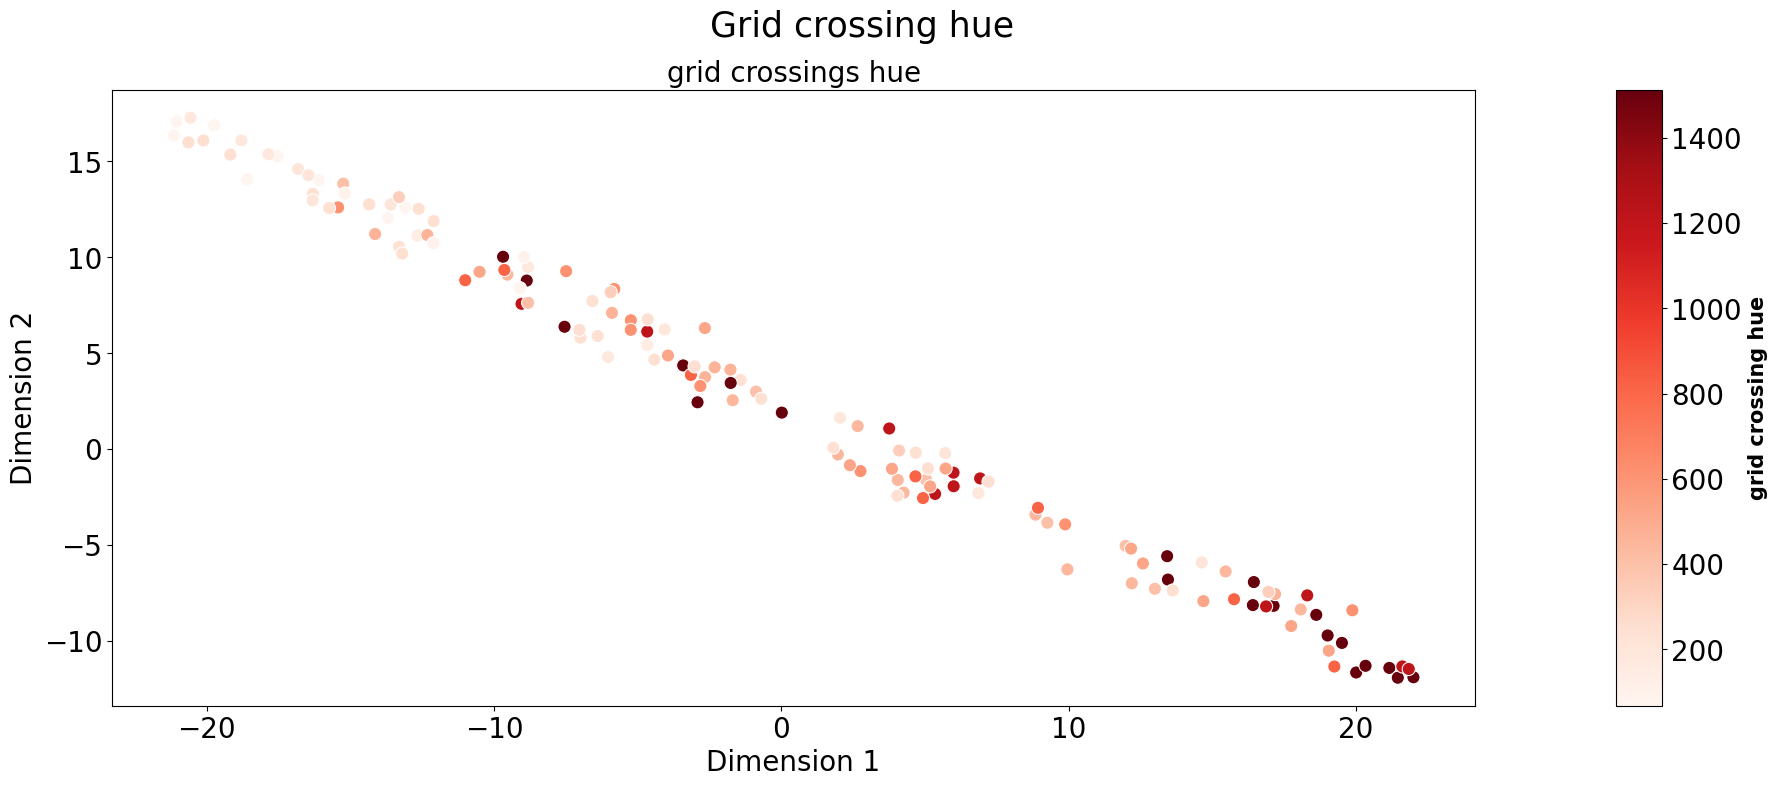

In [34]:
# use the function scatter_tsne_morph_plot to build the scatter plot of the t-SNE embeddings
# with the grid crossing as the hue
# and subtype as the size
scatter_tsne_morph_plot('grid crossings', 'subtype', 'Grid crossing hue',
                        save=False, save_path='./plots/mix_subtype_morph_p_tsne_perplexity_{}.png'.format(perplexity),
                        font_size=20, legend_font_size=15, tick_size=20)

No handles with labels found to put in legend.


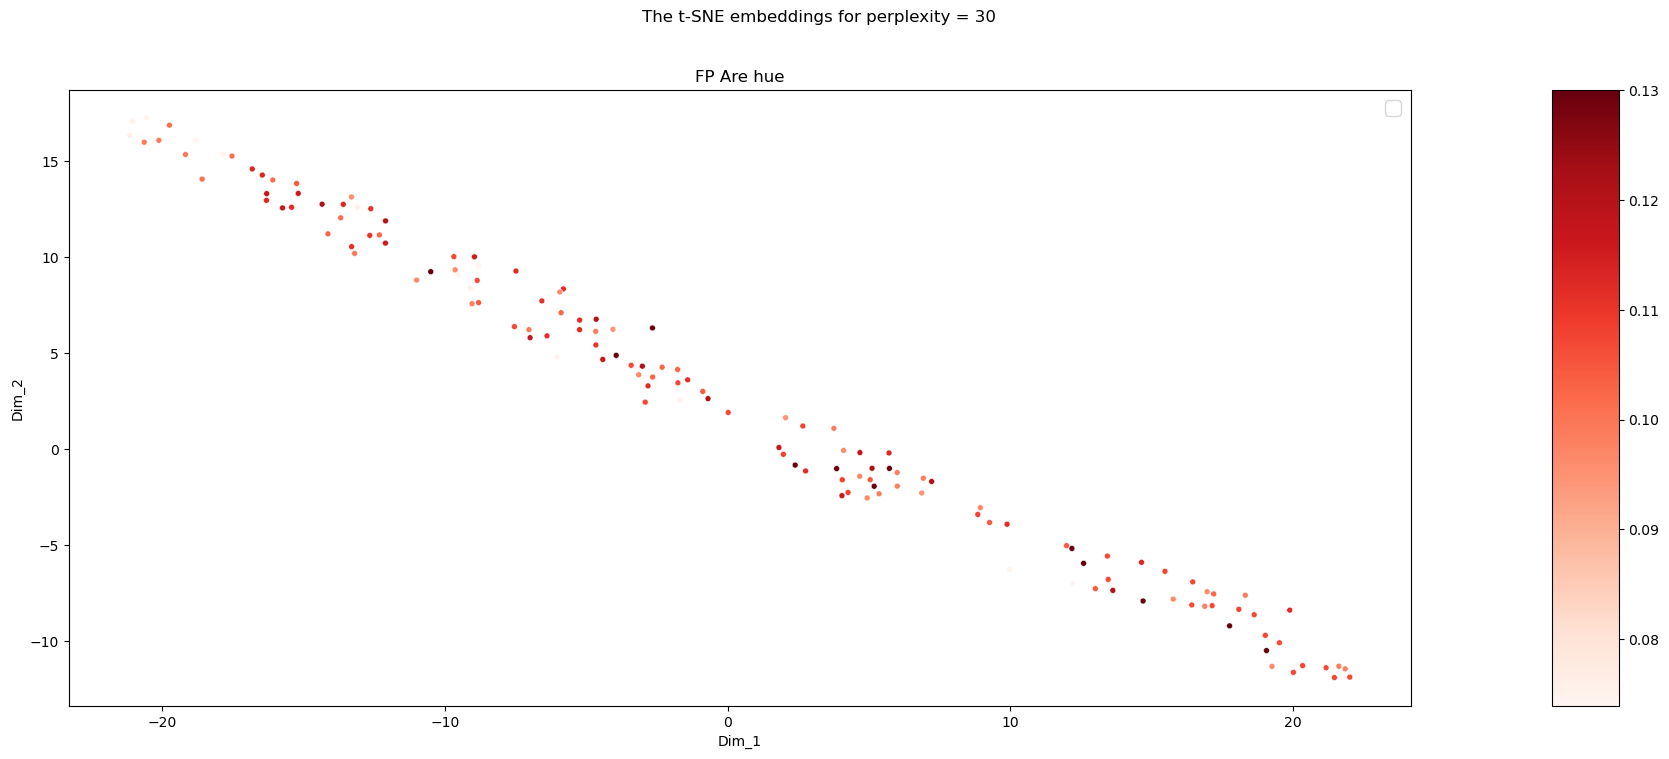

In [35]:
# for the perplexity value of
perplexity : float = 30

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,8), gridspec_kw={'width_ratios': [20, 1]},
                    sharey=False)

tsne_morphs_df = tsne_morph_dfs['perplexity='+str(perplexity)]

ax = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
                     hue=tsne_morphs_df['FP Area'], palette='Reds', 
                     size = 6, legend=False, ax=axs[0])

plt.suptitle('The t-SNE embeddings for perplexity = {}'.format(perplexity))

ax.set_title('FP Are hue')

norm = plt.Normalize(tsne_morphs_df['FP Area'].min(), tsne_morphs_df['FP Area'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, cax=axs[1], fraction=0.01, pad=0.01)
ax.legend()

No handles with labels found to put in legend.


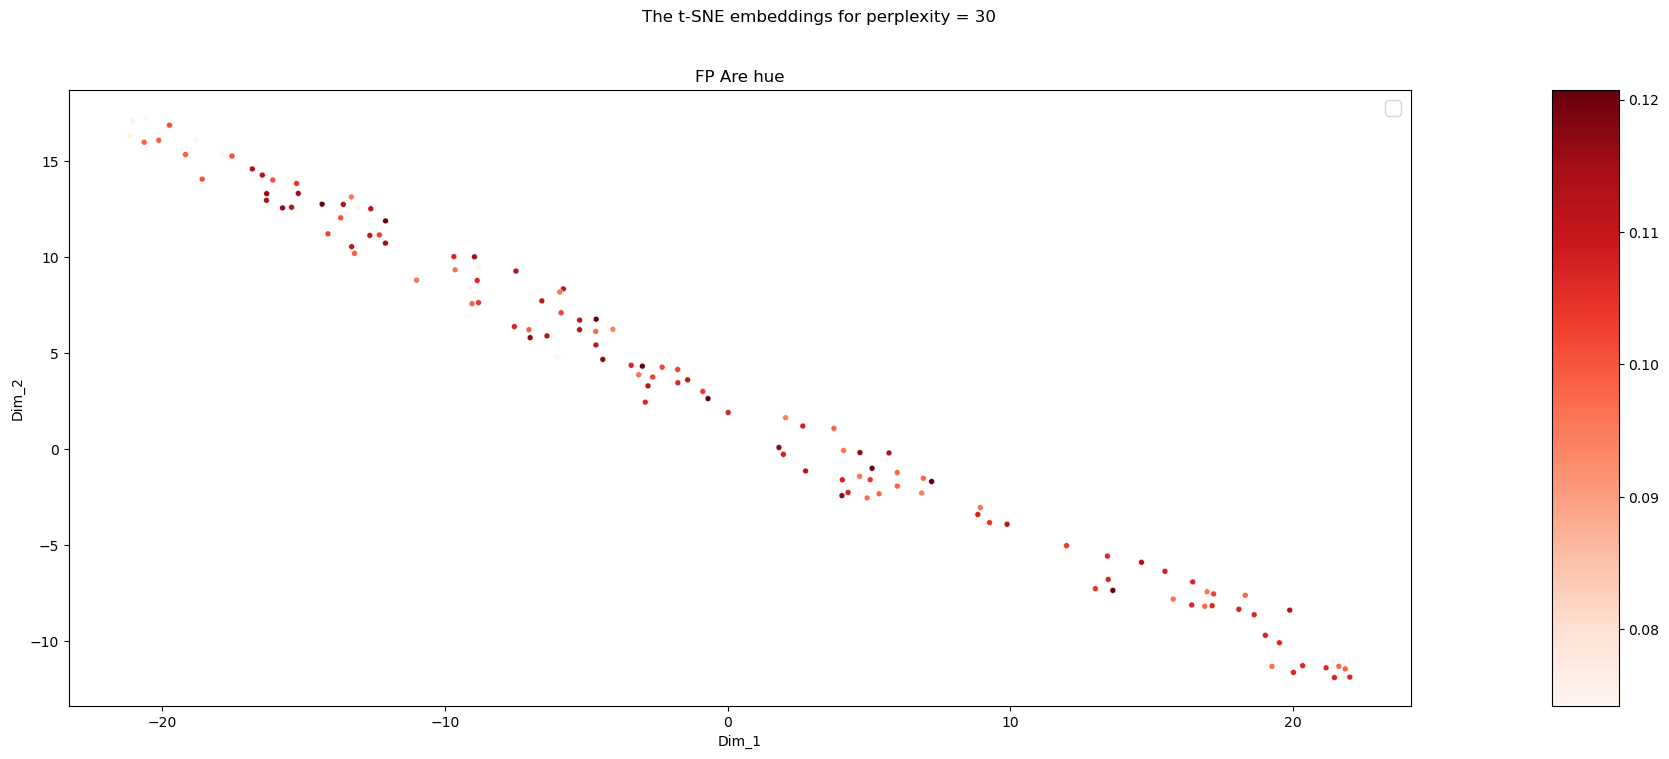

In [36]:
# for the perplexity value of
perplexity : float = 30

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,8), gridspec_kw={'width_ratios': [20, 1]},
                    sharey=False)

tsne_cleansed_df = tsne_cleansed_dfs['perplexity='+str(perplexity)]
ax = sn.scatterplot(x=tsne_cleansed_df['Dim_1'], y=tsne_cleansed_df['Dim_2'], 
                     hue=tsne_cleansed_df['FP Area'], palette='Reds', 
                     size = 6, legend=False, ax=axs[0])

plt.suptitle('The t-SNE embeddings for perplexity = {}'.format(perplexity))

ax.set_title('FP Are hue')

norm = plt.Normalize(tsne_cleansed_df['FP Area'].min(), tsne_cleansed_df['FP Area'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, cax=axs[1], fraction=0.01, pad=0.01)
ax.legend()

No handles with labels found to put in legend.


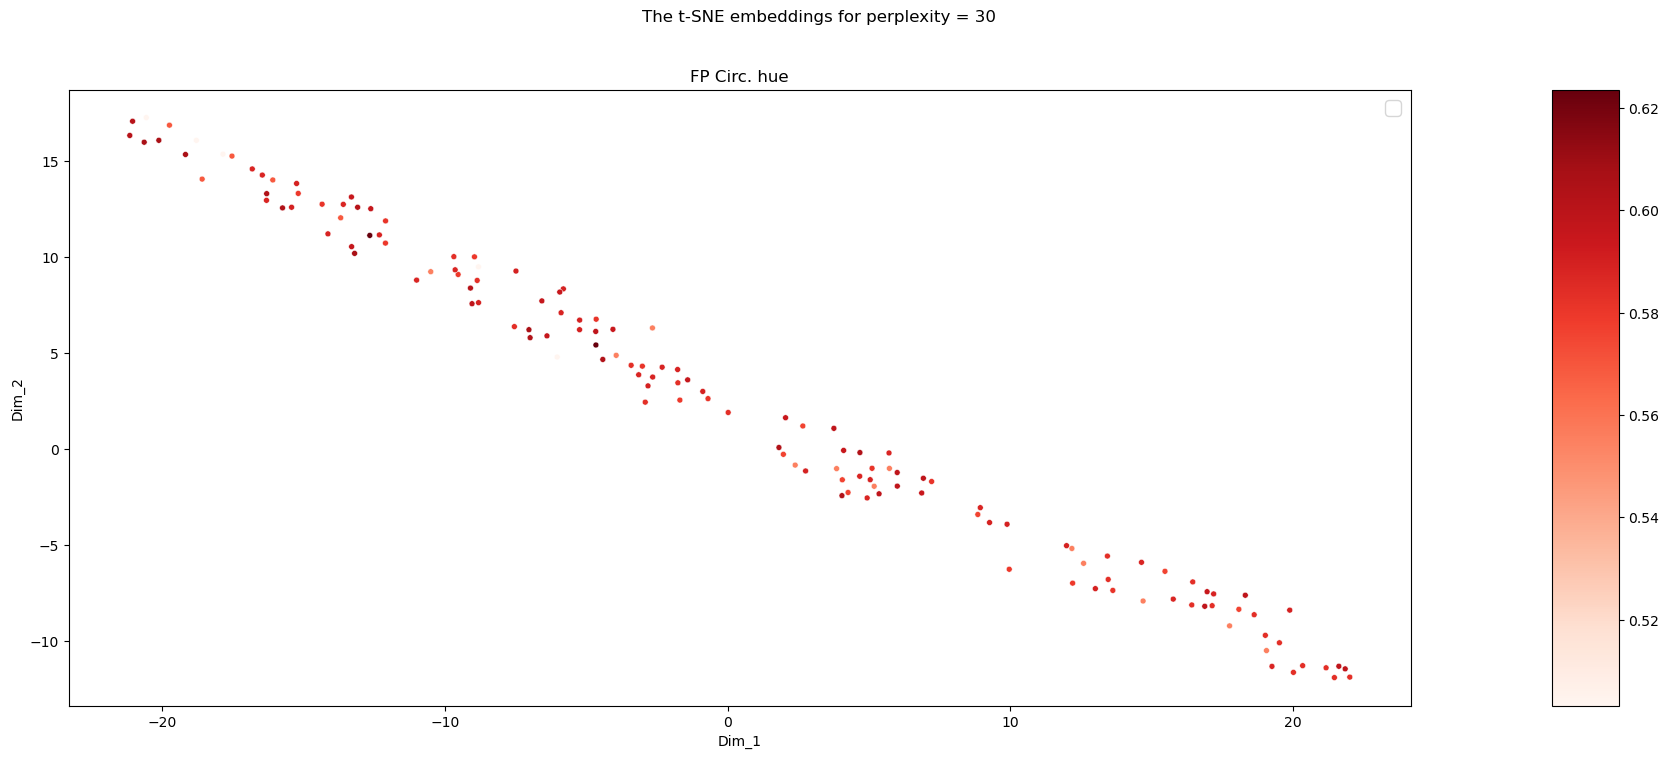

In [37]:
# for the perplexity value of
perplexity : float = 30
hue_param : str = 'FP Circ.'

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,8), gridspec_kw={'width_ratios': [20, 1]},
                    sharey=False)

tsne_morphs_df = tsne_morph_dfs['perplexity='+str(perplexity)]

ax = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
                     hue=tsne_morphs_df[hue_param], palette='Reds', 
                     size = 6, legend=False, ax=axs[0])

plt.suptitle('The t-SNE embeddings for perplexity = {}'.format(perplexity))

ax.set_title('{} hue'.format(hue_param))

norm = plt.Normalize(tsne_morphs_df[hue_param].min(), tsne_morphs_df[hue_param].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, cax=axs[1], fraction=0.01, pad=0.01)
ax.legend()

No handles with labels found to put in legend.


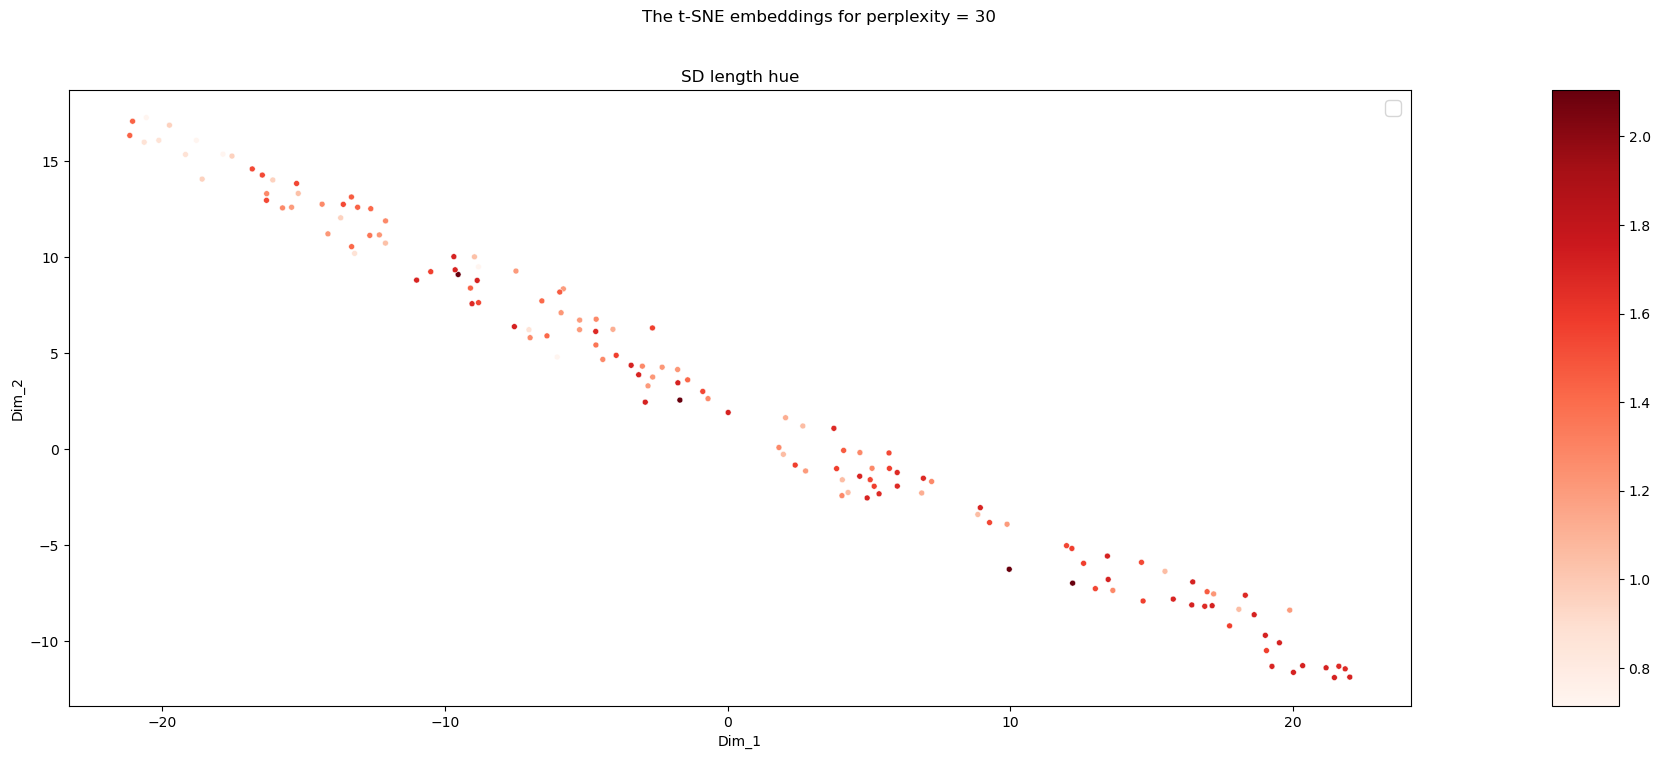

In [38]:
# for the perplexity value of
perplexity : float = 30
hue_param : str = 'SD length'

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,8), gridspec_kw={'width_ratios': [20, 1]},
                    sharey=False)

tsne_morphs_df = tsne_morph_dfs['perplexity='+str(perplexity)]

ax = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
                     hue=tsne_morphs_df[hue_param], palette='Reds', 
                     size = 6, legend=False, ax=axs[0])

plt.suptitle('The t-SNE embeddings for perplexity = {}'.format(perplexity))

ax.set_title('{} hue'.format(hue_param))

norm = plt.Normalize(tsne_morphs_df[hue_param].min(), tsne_morphs_df[hue_param].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, cax=axs[1], fraction=0.01, pad=0.01)
ax.legend()

No handles with labels found to put in legend.


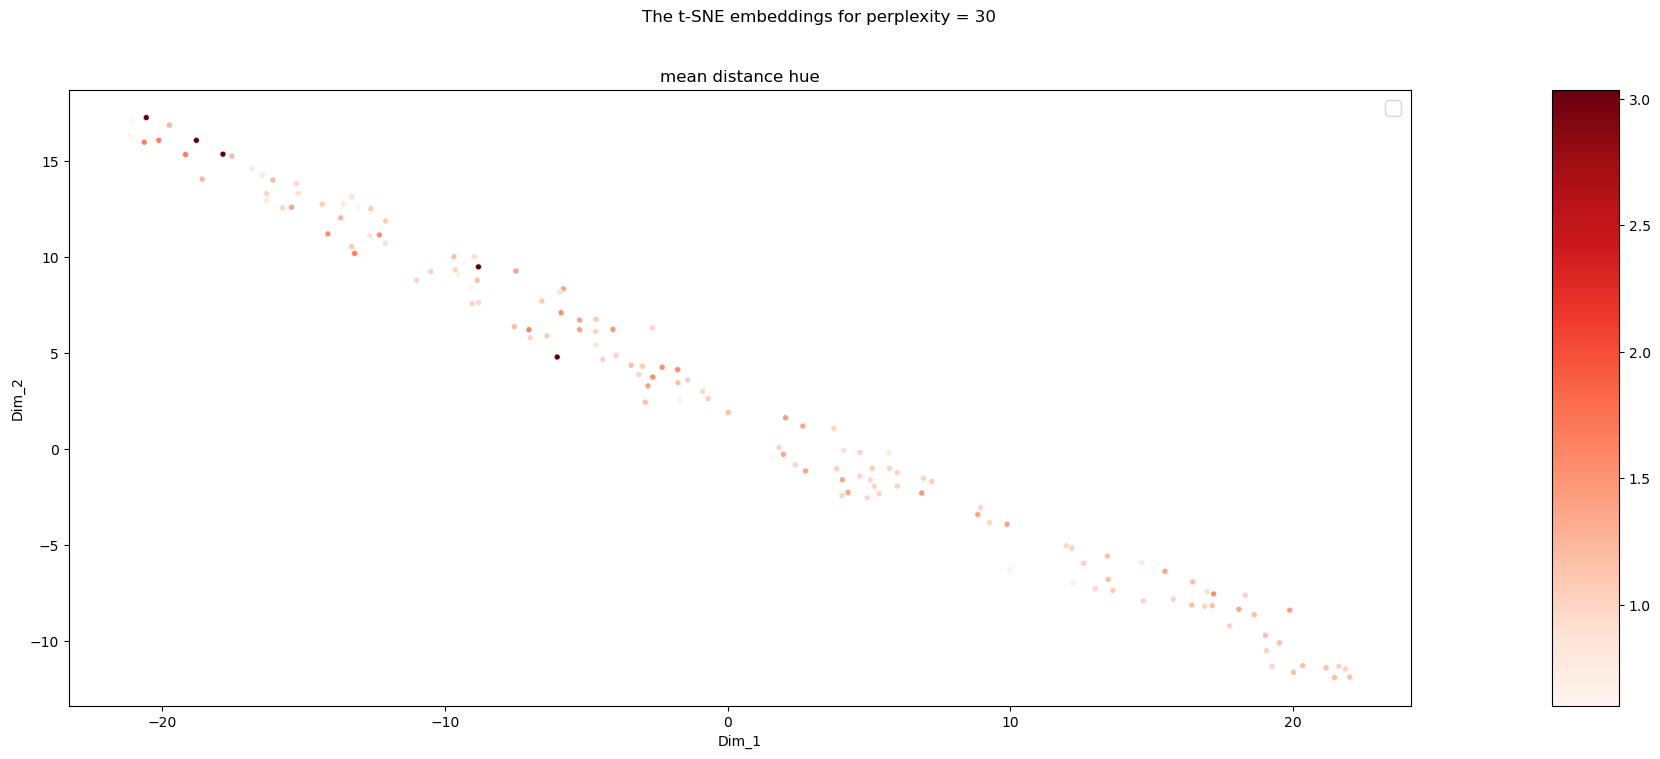

In [39]:
# for the perplexity value of
perplexity : float = 30
hue_param : str = 'mean distance'

fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,8), gridspec_kw={'width_ratios': [20, 1]},
                    sharey=False)

tsne_morphs_df = tsne_morph_dfs['perplexity='+str(perplexity)]

ax = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
                     hue=tsne_morphs_df[hue_param], palette='Reds', 
                     size = 6, legend=False, ax=axs[0])

plt.suptitle('The t-SNE embeddings for perplexity = {}'.format(perplexity))

ax.set_title('{} hue'.format(hue_param))

norm = plt.Normalize(tsne_morphs_df[hue_param].min(), tsne_morphs_df[hue_param].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax.figure.colorbar(sm, cax=axs[1], fraction=0.01, pad=0.01)
ax.legend()

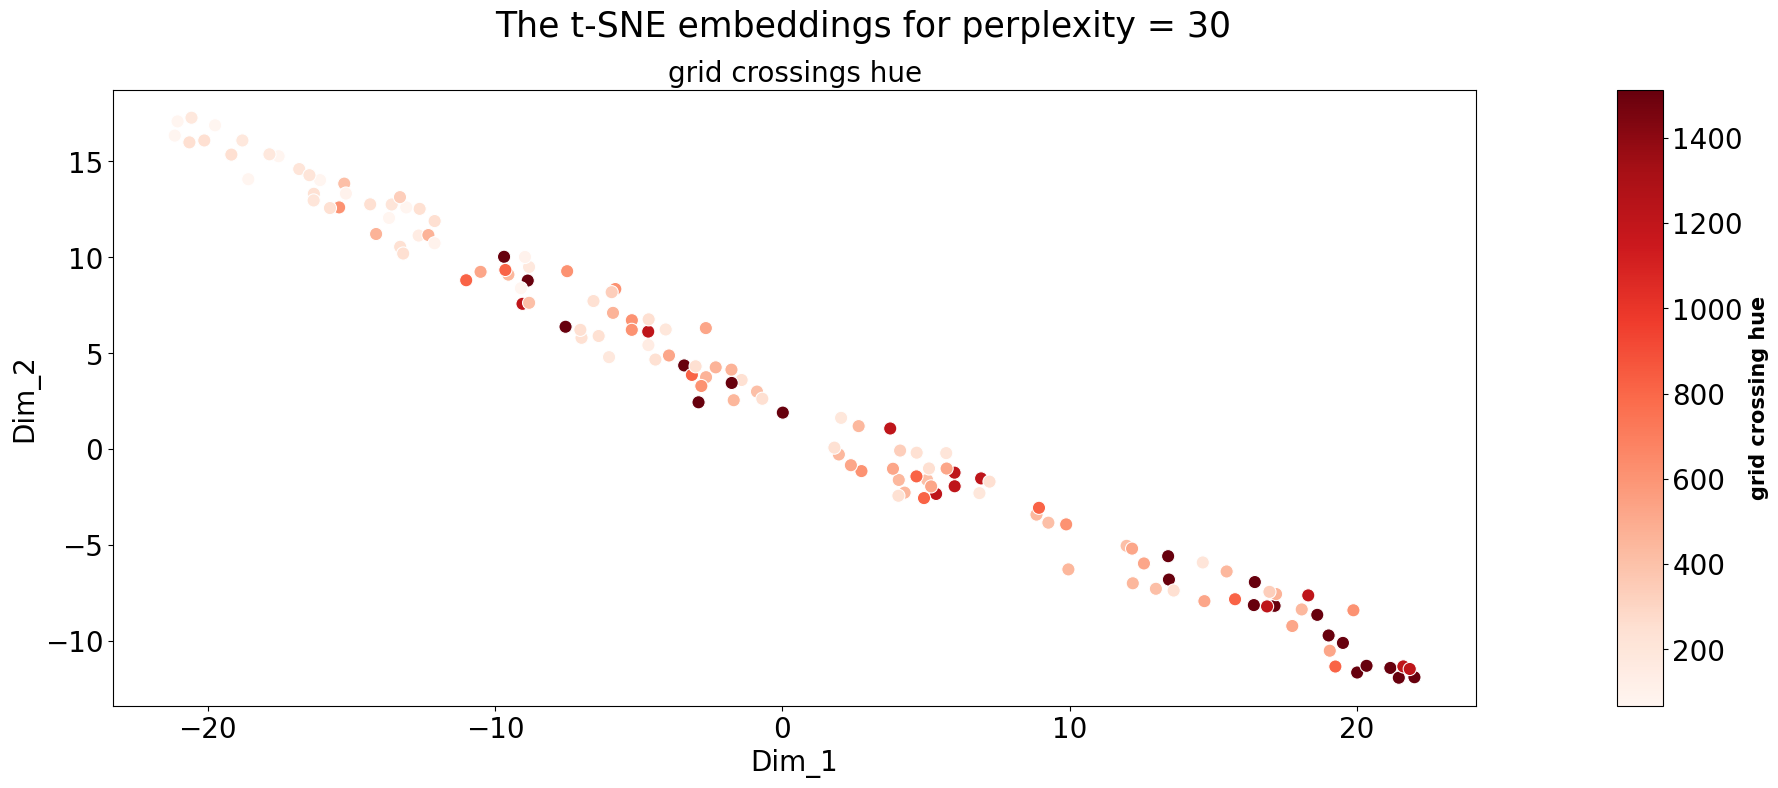

In [40]:
# for the perplexity value of
perplexity : float = 30
tsne_morphs_df = tsne_morph_dfs['perplexity='+str(perplexity)]

morph_params = ['FP Area', 'FP Circ.', 'SD length', 'grid crossings']
morph_param = morph_params[3]

# ref_params = ['Subtype', 'PU prot/crea (g/g)']
# ref_param = ref_params[0]

tsne_morphs_df = tsne_morph_dfs['perplexity={}'.format(perplexity)]

plt.rc('legend',fontsize='x-large')


fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(20,8), gridspec_kw={'width_ratios': [30, 1]},
                        sharey=False)

# ax0 = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
#                      hue=tsne_morphs_df[ref_param],
#                      s = 12, legend=True, ax=axs[0])

ax2 = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
                     hue=tsne_morphs_df[morph_param], palette='Reds', 
                     s = 90, legend=False, ax=axs[0])

plt.suptitle('The t-SNE embeddings for perplexity = {}'.format(perplexity), 
             fontsize=25)

# ax0.set_title('{} hue'.format(ref_param), fontsize=15)
ax2.set_title('{} hue'.format(morph_param), fontsize=20)


norm = plt.Normalize(tsne_morphs_df[morph_param].min(), tsne_morphs_df[morph_param].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])

# ax2.set_title('{} hue'.format(hue_param), fontsize=20)

ax2.figure.axes[0].tick_params(labelsize=20)

ax2.figure.axes[1].tick_params(labelsize=20)

ax2.figure.axes[0].set_xlabel('Dim_1', fontsize=20)
ax2.figure.axes[0].set_ylabel('Dim_2', fontsize=20)


cb = ax2.figure.colorbar(sm, cax=axs[1], fraction=0.01, pad=0.01)
# cb.set_label(label='a label', weight='bold')
cb.set_label(label='grid crossing hue',size=15,weight='bold')
# ax2.legend()

# save the figure to a file named "mix_subtype_morph_p_tsne_perplexity_{}.png".format(perplexity) in the folder "./plots"
plt.savefig('./plots/{}_mix_subtype_morph_tsne_perplexity_{}.png'.format(morph_param, perplexity), facecolor='w')

## Double plots (left: genetic subtype or protein conc-n hue, right: morph. parameter hue)

In [41]:
for df_name,df in tsne_morph_dfs.items():
    tsne_morph_dfs[df_name] = df.reset_index()

In [42]:
# using the dictionary subtype_embeds create a new column in each dataframe
# that contains string values respective to the Name values
# inside the dictionary tsne_morph_dfs
for df_name,df in tsne_morph_dfs.items():
    tsne_morph_dfs[df_name]['Subtype'] = tsne_morph_dfs[df_name]['Name'].map(subtype_embeds)

In [43]:
for df,v in tsne_morph_dfs.items():
    v['Subtype'] = v['Subtype'].fillna('Human')
    # replace "other" values in column "Subtype" with "Other mouse"
    v['Subtype'] = v['Subtype'].replace('other', 'Other mouse')

In [44]:
set(tsne_morph_dfs['perplexity=30']['Subtype'])

{'Human', 'Other mouse', 'adr', 'ntn'}

No handles with labels found to put in legend.


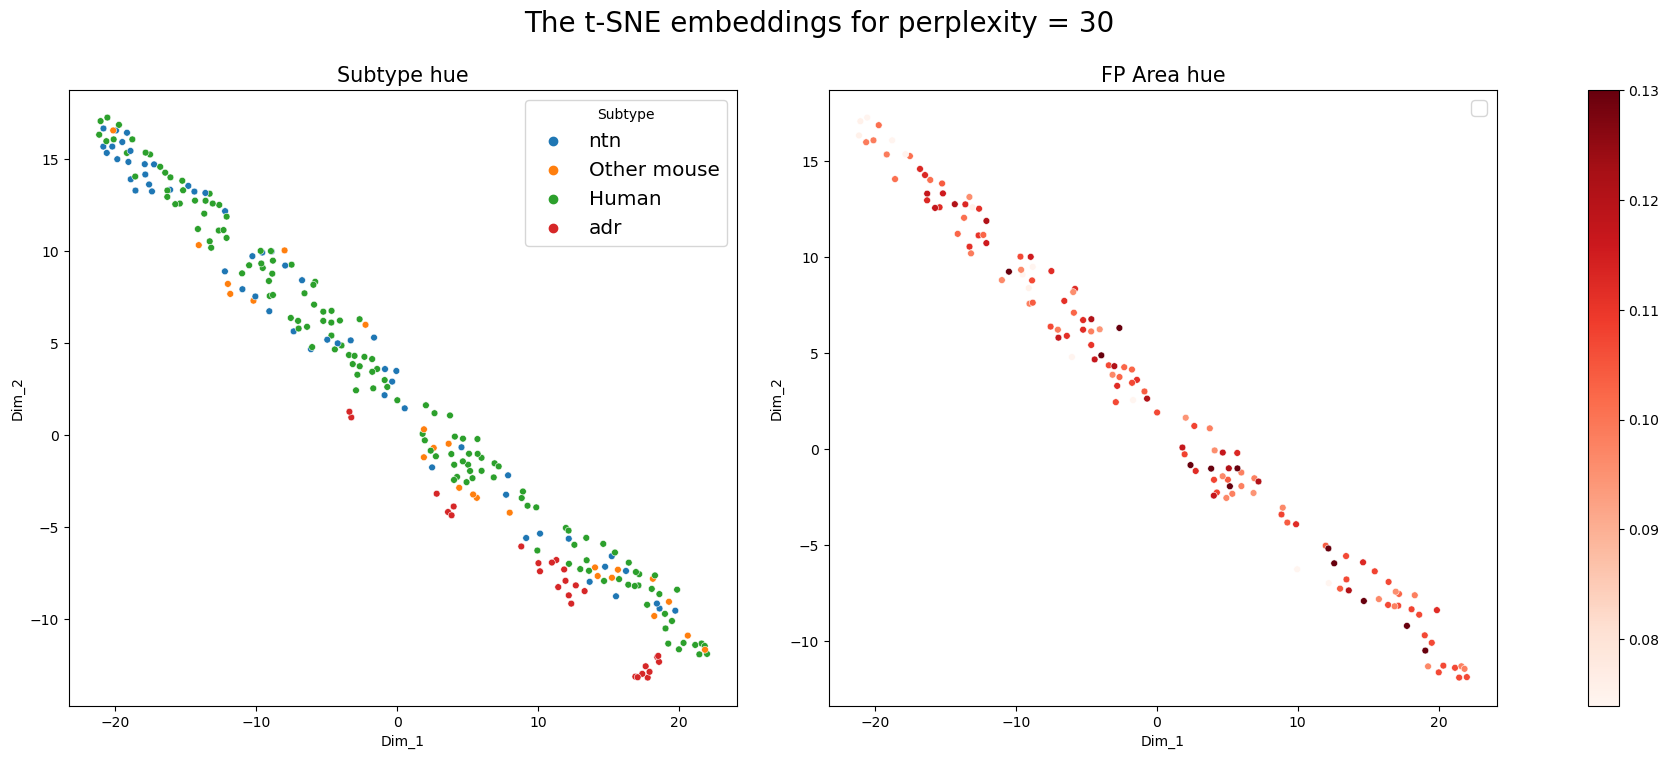

In [45]:
# for the perplexity value of
perplexity : float = 30
plt.rc('legend',fontsize='x-large')
tsne_morphs_df = tsne_morph_dfs['perplexity='+str(perplexity)]

morph_params = ['FP Area', 'FP Circ.', 'SD length', 'grid crossings']
morph_param = morph_params[0]

ref_params = ['Subtype', 'PU prot/crea (g/g)']
ref_param = ref_params[0]

tsne_morphs_df = tsne_morph_dfs['perplexity={}'.format(perplexity)]


fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20,8), gridspec_kw={'width_ratios': [22, 22, 1]},
                        sharey=False)

ax0 = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
                     hue=tsne_morphs_df[ref_param],
                     s = 24, legend=True, ax=axs[0])

ax2 = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
                     hue=tsne_morphs_df[morph_param], palette='Reds', 
                     s = 24, legend=False, ax=axs[1])

plt.suptitle('The t-SNE embeddings for perplexity = {}'.format(perplexity), fontsize=20)

ax0.set_title('{} hue'.format(ref_param), fontsize=15)
ax2.set_title('{} hue'.format(morph_param), fontsize=15)

norm = plt.Normalize(tsne_morphs_df[morph_param].min(), tsne_morphs_df[morph_param].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax2.figure.colorbar(sm, cax=axs[2], fraction=0.01, pad=0.01)
ax2.legend()

# save the figure to a file named "mix_subtype_morph_p_tsne_perplexity_{}.png".format(perplexity) in the folder "./plots"
plt.savefig('./plots/{}_mix_subtype_morph_tsne_perplexity_{}.png'.format(morph_param, perplexity), facecolor='w')

No handles with labels found to put in legend.


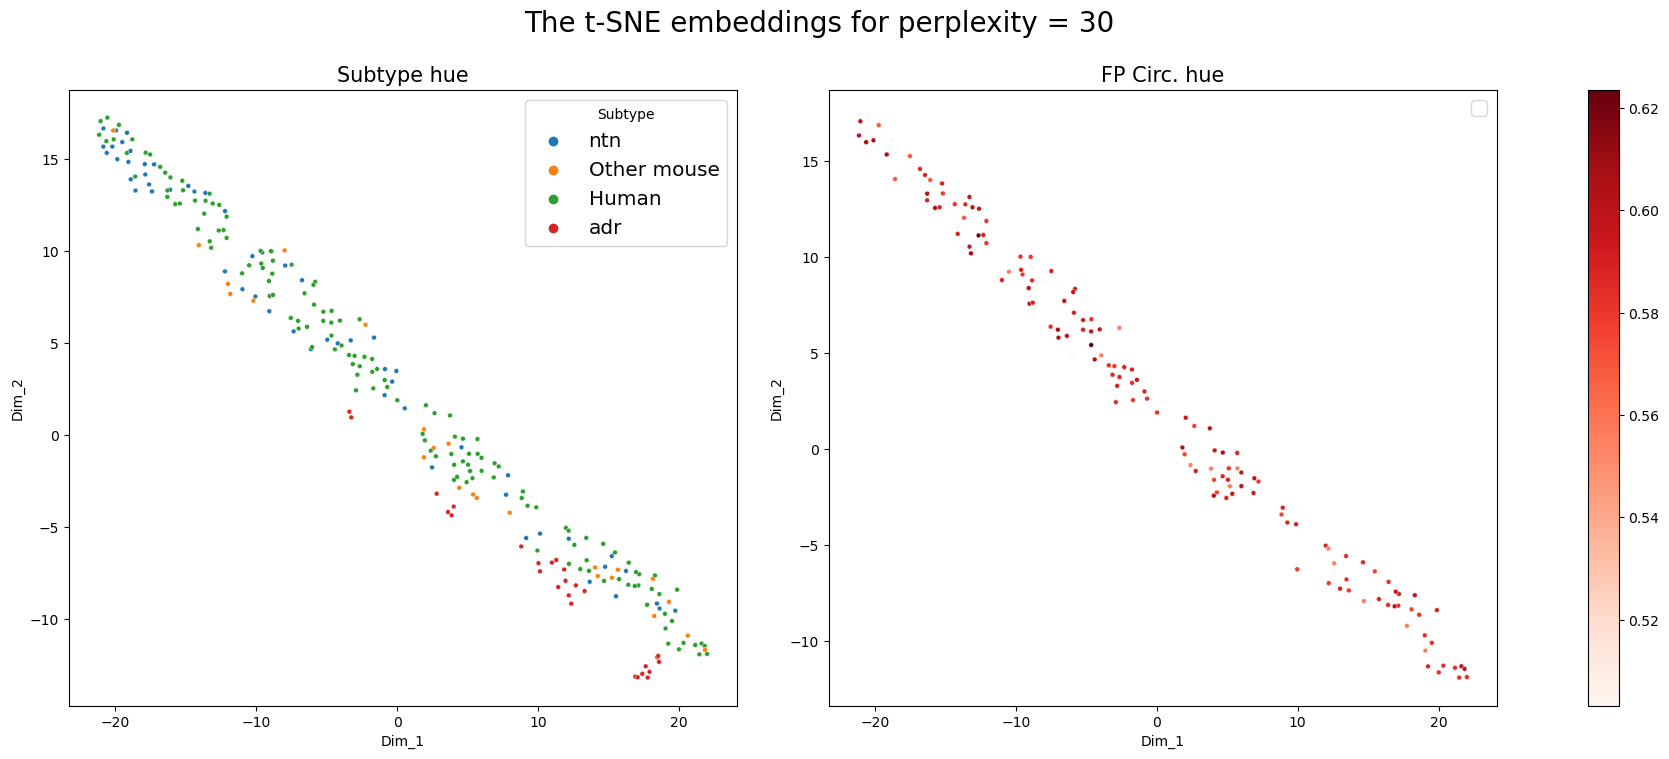

In [46]:

# for the perplexity value of
perplexity : float = 30
plt.rc('legend',fontsize='x-large')
tsne_morphs_df = tsne_morph_dfs['perplexity='+str(perplexity)]

morph_params = ['FP Area', 'FP Circ.', 'SD length', 'grid crossings']
morph_param = morph_params[1]

ref_params = ['Subtype', 'PU prot/crea (g/g)']
ref_param = ref_params[0]

tsne_morphs_df = tsne_morph_dfs['perplexity={}'.format(perplexity)]


fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20,8), gridspec_kw={'width_ratios': [22, 22, 1]},
                        sharey=False)

ax0 = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
                     hue=tsne_morphs_df[ref_param],
                     s = 12, legend=True, ax=axs[0])

ax2 = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
                     hue=tsne_morphs_df[morph_param], palette='Reds', 
                     s = 12, legend=False, ax=axs[1])

plt.suptitle('The t-SNE embeddings for perplexity = {}'.format(perplexity), fontsize=20)

ax0.set_title('{} hue'.format(ref_param), fontsize=15)
ax2.set_title('{} hue'.format(morph_param), fontsize=15)


norm = plt.Normalize(tsne_morphs_df[morph_param].min(), tsne_morphs_df[morph_param].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax2.figure.colorbar(sm, cax=axs[2], fraction=0.01, pad=0.01)
ax2.legend()

# save the figure to a file named "mix_subtype_morph_p_tsne_perplexity_{}.png".format(perplexity) in the folder "./plots"
plt.savefig('./plots/{}_mix_subtype_morph_tsne_perplexity_{}.png'.format(morph_param, perplexity), facecolor='w')

No handles with labels found to put in legend.


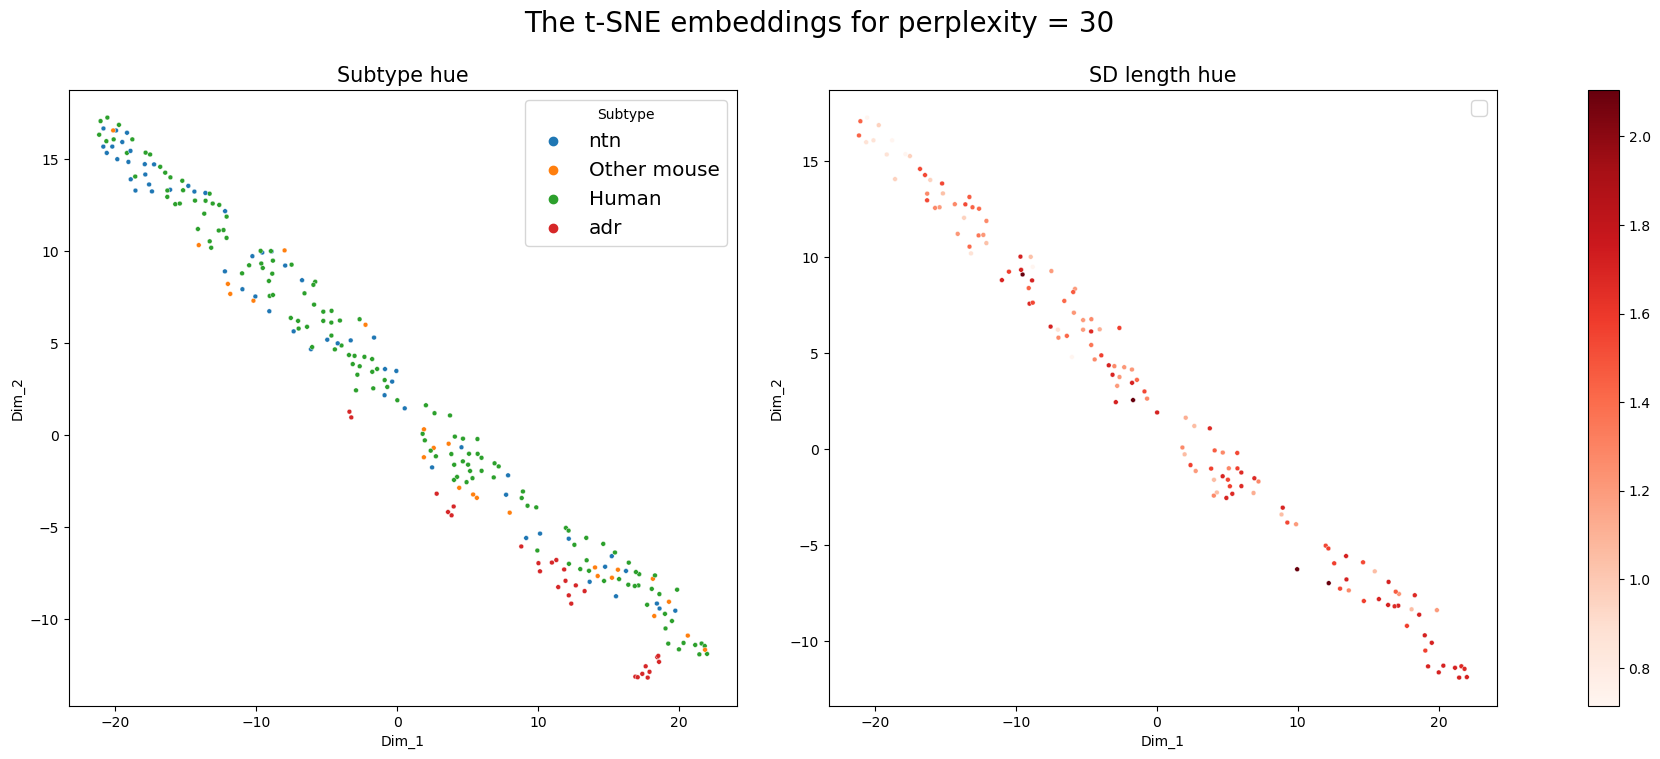

In [47]:

# for the perplexity value of
perplexity : float = 30
plt.rc('legend',fontsize='x-large')
tsne_morphs_df = tsne_morph_dfs['perplexity='+str(perplexity)]

morph_params = ['FP Area', 'FP Circ.', 'SD length', 'grid crossings']
morph_param = morph_params[2]

ref_params = ['Subtype', 'PU prot/crea (g/g)']
ref_param = ref_params[0]

tsne_morphs_df = tsne_morph_dfs['perplexity={}'.format(perplexity)]


fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20,8), gridspec_kw={'width_ratios': [22, 22, 1]},
                        sharey=False)

ax0 = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
                     hue=tsne_morphs_df[ref_param],
                     s = 12, legend=True, ax=axs[0])

ax2 = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
                     hue=tsne_morphs_df[morph_param], palette='Reds', 
                     s = 12, legend=False, ax=axs[1])

plt.suptitle('The t-SNE embeddings for perplexity = {}'.format(perplexity), fontsize=20)

ax0.set_title('{} hue'.format(ref_param), fontsize=15)
ax2.set_title('{} hue'.format(morph_param), fontsize=15)


norm = plt.Normalize(tsne_morphs_df[morph_param].min(), tsne_morphs_df[morph_param].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax2.figure.colorbar(sm, cax=axs[2], fraction=0.01, pad=0.01)
ax2.legend()

# save the figure to a file named "mix_subtype_morph_p_tsne_perplexity_{}.png".format(perplexity) in the folder "./plots"
plt.savefig('./plots/{}_mix_subtype_morph_tsne_perplexity_{}.png'.format(morph_param, perplexity), facecolor='w')

No handles with labels found to put in legend.


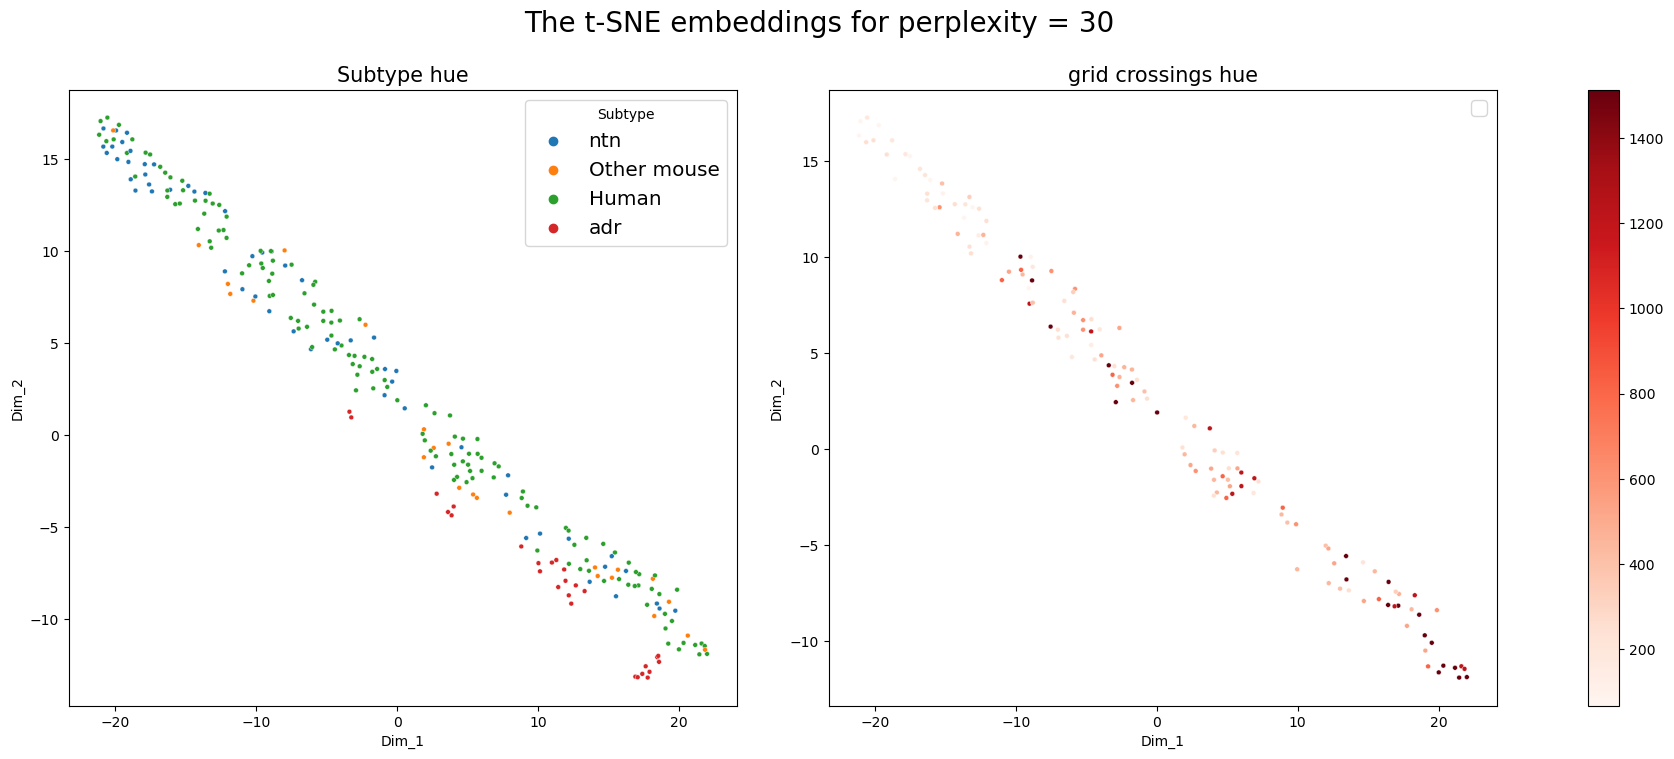

In [48]:
# for the perplexity value of
perplexity : float = 30
tsne_morphs_df = tsne_morph_dfs['perplexity='+str(perplexity)]

morph_params = ['FP Area', 'FP Circ.', 'SD length', 'grid crossings']
morph_param = morph_params[3]

ref_params = ['Subtype', 'PU prot/crea (g/g)']
ref_param = ref_params[0]

tsne_morphs_df = tsne_morph_dfs['perplexity={}'.format(perplexity)]

plt.rc('legend',fontsize='x-large')


fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(20,8), gridspec_kw={'width_ratios': [22, 22, 1]},
                        sharey=False)

ax0 = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
                     hue=tsne_morphs_df[ref_param],
                     s = 12, legend=True, ax=axs[0])

ax2 = sn.scatterplot(x=tsne_morphs_df['Dim_1'], y=tsne_morphs_df['Dim_2'], 
                     hue=tsne_morphs_df[morph_param], palette='Reds', 
                     s = 12, legend=False, ax=axs[1])

plt.suptitle('The t-SNE embeddings for perplexity = {}'.format(perplexity), fontsize=20)

ax0.set_title('{} hue'.format(ref_param), fontsize=15)
ax2.set_title('{} hue'.format(morph_param), fontsize=15)


norm = plt.Normalize(tsne_morphs_df[morph_param].min(), tsne_morphs_df[morph_param].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])
ax2.figure.colorbar(sm, cax=axs[2], fraction=0.01, pad=0.01)
ax2.legend()

# save the figure to a file named "mix_subtype_morph_p_tsne_perplexity_{}.png".format(perplexity) in the folder "./plots"
plt.savefig('./plots/{}_mix_subtype_morph_tsne_perplexity_{}.png'.format(morph_param, perplexity), facecolor='w')

# Plotly plots

In [55]:
import plotly.tools as tls
from plotly.offline import download_plotlyjs, plot,iplot

In [56]:
# for the perplexity value of
perplexity : float = 5

fig = tls.make_subplots(rows=2, cols=1)

norm = plt.Normalize(tsne_cleansed_dfs['perplexity=5']['PU prot/crea (g/g)'].min(), tsne_cleansed_dfs['perplexity=5']['PU prot/crea (g/g)'].max())
sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
sm.set_array([])


fig_1 = tsne_cleansed_dfs['perplexity=5'].plot(kind='scatter', x='Dim_1', y='Dim_2')

fig.append_trace(fig_1, 1, 1)

fig_2 = tsne_cleansed_dfs['perplexity=5'].plot(kind='scatter', x='Dim_1', y='Dim2')
fig.append_trace(fig_2, 2, 1)

iplot(fig)

/home/gsergei/anaconda3/envs/py37_cheops/lib/python3.7/site-packages/plotly/tools.py:465: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



KeyError: 'PU prot/crea (g/g)'

In [51]:
for name_df, df in tsne_cleansed_dfs.items():
    df.to_csv(name_df+'.csv')

In [52]:
def build_matplot(perplexity : int, **kwargs):
    # for the perplexity value of
    perplexity : float = 5

    fig = tls.make_subplots(rows=2, cols=1)

    norm = plt.Normalize(tsne_cleansed_dfs['perplexity=5']['PU prot/crea (g/g)'].min(), tsne_cleansed_dfs['perplexity=5']['PU prot/crea (g/g)'].max())
    sm = plt.cm.ScalarMappable(cmap="Reds", norm=norm)
    sm.set_array([])


    fig_1 = tsne_cleansed_dfs['perplexity=5'].plot(kind='scatter', x='Dim_1', y='Dim_2')

    fig.append_trace(fig_1, 1, 1)

    fig_2 = tsne_cleansed_dfs['perplexity=5'].plot(kind='scatter', x='Dim_1', y='Dim2')
    fig.append_trace(fig_2, 2, 1)

    iplot(fig)

In [53]:
import plotly
import plotly.offline as py
import plotly.graph_objs as go

In [54]:
def figures_to_html(figs, filename="dashboard.html"):
    with open(filename, 'w') as dashboard:
        dashboard.write("<html><head></head><body>" + "\n")
        for fig in figs:
            inner_html = fig.to_html().split('<body>')[1].split('</body>')[0]
            dashboard.write(inner_html)
        dashboard.write("</body></html>" + "\n")

perplexity : int = 30

# Example figures
import plotly.express as px

fig1 = px.scatter(tsne_morphs_dfs['perplexity='+str(perplexity)], x="Dim_1", y="Dim_2", title='t-SNE projections', color='PU prot/crea (g/g)')

fig2 = px.scatter(tsne_morphs_dfs['perplexity='+str(perplexity)], x="Dim_1", y="Dim_2", color='SD length')

figures_to_html([fig1, fig2])

NameError: name 'tsne_morphs_dfs' is not defined